 ## pipeline

In [6]:
import numpy as np
import os
import pickle
import copy
import edt
import matplotlib.pyplot as plt
import time
import cv2
import pandas as pd
from sklearn.metrics.cluster import adjusted_rand_score
from skimage.metrics import adapted_rand_error

import torch
from torch import from_numpy as from_numpy
from torchsummary import summary

from func.run_pipeline_super_vox import segment_super_vox_3_channel, semantic_segment_crop_and_cat_3_channel_output, img_3d_erosion_or_expansion, \
generate_super_vox_by_watershed, get_outlayer_of_a_3d_shape, get_crop_by_pixel_val, Cluster_Super_Vox, assign_boudary_voxels_to_cells_with_watershed, \
delete_too_small_cluster, reassign
from func.run_pipeline import segment, assign_boudary_voxels_to_cells, dbscan_of_seg, semantic_segment_crop_and_cat
from func.cal_accuracy import IOU_and_Dice_Accuracy, VOI
from func.network import VoxResNet, CellSegNet_basic_lite
from func.unet_3d_basic import UNet3D_basic
from func.ultis import save_obj, load_obj

# graph import stuff
from func.graph_learning import SuperVoxToNxGraph, VoxelGraphDataset, Cluster_Super_Vox_Graph
from func.graph_models import GCN

### init model

In [7]:
# model=UNet3D_basic(in_channels = 1, out_channels = 3)
# load_path=''
# model=VoxResNet(input_channel=1, n_classes=3, output_func = "softmax")
# load_path=""
model=CellSegNet_basic_lite(input_channel=1, n_classes=3, output_func = "softmax")
load_path='output/model_HMS_delete_fake_cells.pkl'
checkpoint = torch.load(load_path)
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# load graph model
graph_model = GCN(3, num_classes=2)
checkpoint_graph = 'output/graph_model.pt'
graph_model.load_state_dict(torch.load(checkpoint_graph))
graph_model.eval()

#summary(model, (1, 64, 64, 64))

GCN(
  (conv1): GraphConv(in=3, out=4, normalization=both, activation=None)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv2): GraphConv(in=4, out=2, normalization=both, activation=None)
)

### dataset info

In [8]:
HMS_data_dict = load_obj("dataset_info/HMS_dataset_info")
HMS_data_dict_test = HMS_data_dict["test"]

### seg one img

parameter setting

In [9]:
# we do not input the whole raw image to the model one time but input raw image crops
crop_cube_size=64
stride=32

# hyperparameter for TASCAN, min touching area of two super pixels if they belong to the same cell
min_touching_area=30

choose a test image and load it

In [10]:
print("Test cases: "+str(HMS_data_dict_test.keys()))
case = "135"
print("for test case "+str(case)+" : "+str(HMS_data_dict_test[case]))

# you may load the image using another path
raw_img=np.load(HMS_data_dict_test[case]["raw"]).astype(float)
hand_seg=np.load(HMS_data_dict_test[case]["ins"]).astype(float)

Test cases: dict_keys(['135', '120', '65', '90'])
for test case 135 : {'raw': 'data/CellSeg_dataset/HMS_processed/raw/135.npy', 'background': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_background_3d_mask.npy', 'boundary': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_boundary_3d_mask.npy', 'foreground': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_foreground_3d_mask.npy', 'ins': 'data/CellSeg_dataset/HMS_processed/segmentation/135/135_ins.npy'}


feed raw image crops to the model

In [11]:
start = time.time()

# feed the raw img to the model
print('Feed raw img to model')
raw_img_size=raw_img.shape
    
seg_background_comp = np.zeros(raw_img_size)
seg_boundary_comp = np.zeros(raw_img_size)

transposes = [[0,1,2]]#,[2,0,1],[0,2,1]]
reverse_transposes = [[0,1,2]]#,[1,2,0],[0,2,1]]

for idx, transpose in enumerate(transposes):
    print(str(idx+1)+": Transpose the image to be: "+str(transpose))
    with torch.no_grad():
        seg_img=\
        semantic_segment_crop_and_cat_3_channel_output(raw_img.transpose(transpose), model, device, crop_cube_size=crop_cube_size, stride=stride)
    seg_img_background=seg_img['background']
    seg_img_boundary=seg_img['boundary']
    seg_img_foreground=seg_img['foreground']
    torch.cuda.empty_cache()
    
    # argmax
    print('argmax', end='\r')
    seg=[]
    seg.append(seg_img_background)
    seg.append(seg_img_boundary)
    seg.append(seg_img_foreground)
    seg=np.array(seg)
    seg_argmax=np.argmax(seg, axis=0)
    # probability map to 0 1 segment
    seg_background=np.zeros(seg_img_background.shape)
    seg_background[np.where(seg_argmax==0)]=1
    seg_foreground=np.zeros(seg_img_foreground.shape)
    seg_foreground[np.where(seg_argmax==2)]=1
    seg_boundary=np.zeros(seg_img_boundary.shape)
    seg_boundary[np.where(seg_argmax==1)]=1
        
    seg_background=seg_background.transpose(reverse_transposes[idx])
    seg_foreground=seg_foreground.transpose(reverse_transposes[idx])
    seg_boundary=seg_boundary.transpose(reverse_transposes[idx])
        
    seg_background_comp+=seg_background
    seg_boundary_comp+=seg_boundary
#print("Get model semantic seg by combination")
seg_background_comp = np.array(seg_background_comp>0, dtype=float)
seg_boundary_comp = np.array(seg_boundary_comp>0, dtype=float)
seg_foreground_comp = np.array(1 - seg_background_comp - seg_boundary_comp>0, dtype=float)

end = time.time()

print("Time elapsed: ", end - start)

Feed raw img to model
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Time elapsed:  252.01260375976562


5

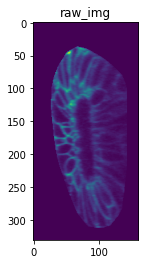

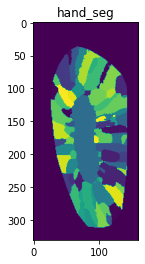

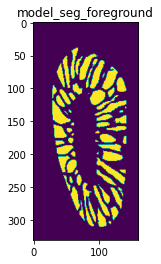

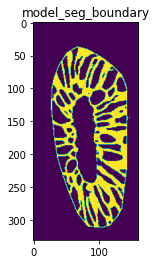

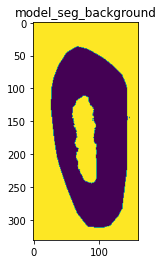

In [12]:
# show current result

N=100

plt.figure()
plt.title("raw_img")
plt.imshow(raw_img[N,:,:])
plt.figure()
plt.title("hand_seg")
plt.imshow(reassign(hand_seg[N,:,:]))
plt.figure()
plt.title("model_seg_foreground")
plt.imshow(seg_foreground_comp[N,:,:])
plt.figure()
plt.title("model_seg_boundary")
plt.imshow(seg_boundary_comp[N,:,:])
plt.figure()
plt.title("model_seg_background")
plt.imshow(seg_background_comp[N,:,:])

TASCAN

generate super vox by watershed

In [13]:
how_close_are_the_super_vox_to_boundary=2
min_touching_percentage=0.51

seg_foreground_erosion=1-img_3d_erosion_or_expansion(1-seg_foreground_comp, kernel_size=how_close_are_the_super_vox_to_boundary+1, device=device)
seg_foreground_super_voxel_by_ws = generate_super_vox_by_watershed(seg_foreground_erosion, connectivity=min_touching_area)

In [14]:
print("There are "+str(len(np.unique(seg_foreground_super_voxel_by_ws)))+" super voxels")

There are 1951 super voxels


super voxel clustearing

In [15]:
# cluster_super_vox=Cluster_Super_Vox(min_touching_area=min_touching_area, min_touching_percentage=min_touching_percentage)
# cluster_super_vox.fit(seg_foreground_super_voxel_by_ws)
# seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img

# import pickle
# pickle.dump(seg_foreground_super_voxel_by_ws, open("test_seg_foreground_super_voxel_by_ws.pkl", "wb" ))

In [16]:
cluster_super_vox=Cluster_Super_Vox_Graph(graph_model)
cluster_super_vox.fit(seg_foreground_super_voxel_by_ws, fake_predictions=True)
seg_foreground_single_cell_with_boundary = cluster_super_vox.output_3d_img



getting neighbor pairs
adding neighbor ids
calculate edges
build networkx graph


/opt/anaconda3/envs/CellSeg3D_torch/lib/python3.8/site-packages/dgl/backend/pytorch/tensor.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  return th.as_tensor(data, dtype=dtype)


predict...
FAKE PREDICTIONS
everything predicted!


delete too small cells

In [17]:
min_cell_size_threshold=10
seg_foreground_single_cell_with_boundary_delete_too_small = delete_too_small_cluster(seg_foreground_single_cell_with_boundary, threshold=min_cell_size_threshold)

assign boudary voxels to their nearest cells

In [18]:
seg_final=assign_boudary_voxels_to_cells_with_watershed(seg_foreground_single_cell_with_boundary_delete_too_small, seg_boundary_comp, seg_background_comp, compactness=1)

see the final result

In [19]:
def colorful_seg(seg):
    unique_vals, val_counts = np.unique(seg, return_counts=True)
    
    background_val = unique_vals[np.argsort(val_counts)[::-1][0]]
    
    seg_RGB = []
    for i in range(seg.shape[0]):
        mask_gray = cv2.normalize(src=seg[i,:,:], dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        seg_slice_RGB = cv2.cvtColor(mask_gray, cv2.COLOR_GRAY2RGB)
        seg_RGB.append(seg_slice_RGB)
    seg_RGB = np.array(seg_RGB)
    
    for idx, unique_val in enumerate(unique_vals):
        print(str(idx/len(unique_vals)), end="\r")
        if unique_val == background_val:
            COLOR = np.array([0,0,0], dtype=int)
        else:
            COLOR = np.array(np.random.choice(np.arange(256), size=3, replace=False), dtype=int)
        
        locs = np.where(seg==unique_val)
        
        for i in range(3):
            seg_RGB[locs[0], locs[1], locs[2], i] = COLOR[i]
        
    return seg_RGB

In [20]:
seg_RGB = colorful_seg(seg_final)
hand_seg_RGB = colorful_seg(hand_seg)

0.017647058823529410.035294117647058820.0529411764705882350.070588235294117650.088235294117647060.105882352941176470.123529411764705890.14117647058823530.15882352941176470.176470588235294130.194117647058823530.209803921568627460.225490196078431380.24117647058823530.25686274509803920.274509803921568650.29019607843137260.30588235294117650.32352941176470590.34117647058823530.35882352941176470.37647058823529410.39411764705882350.41176470588235290.42941176470588230.44705882352941180.46274509803921570.48039215686274510.49803921568627450.5156862745098040.53333333333333330.54901960784313730.56666666666666670.58235294117647060.59803921568627450.6156862745098040.63333333333333330.65098039215686280.66862745098039210.68431372549019610.70196078431372540.71960784313725490.73725490196078440.75098039215686270.76470588235294110.77843137254901960.79411764705882350.80980392156862750.82549019607843130.84117647058823530.85686274509803920.87254901960784310.8882352941176470.9039215686274510.91960784313725490

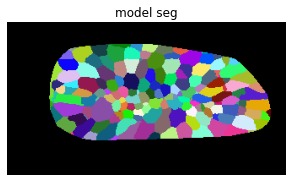

In [21]:
N=100
fig = plt.figure(figsize=(5,5))
plt.title("model seg")
plt.axis('off')
plt.imshow(seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

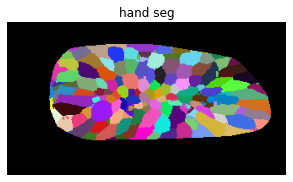

In [22]:
fig = plt.figure(figsize=(5,5))
plt.title("hand seg")
plt.axis('off')
plt.imshow(hand_seg_RGB[:,:,N,:])#, cmap="gray")
#plt.savefig('_RGB_'+str(N)+'.png',bbox_inches='tight',dpi=fig.dpi,pad_inches=0.0)

In [23]:
# print("There are "+str(len(np.unique(seg_final)))+" cells in model prediction")
# print("There are "+str(len(np.unique(hand_seg)))+" cells in hand seg")

calculate accuracy

In [24]:
ARI = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
ARE = adapted_rand_error(hand_seg.astype(int).flatten(), seg_final.astype(int).flatten())
VOI_val = VOI(seg_final.astype(int),hand_seg.astype(int))

In [25]:
print("ARI: "+str(ARI))
print("ARE: "+str(ARE))
print("VOI: "+str(VOI_val))

ARI: 0.9736447398560567
ARE: (0.30875829754599193, 0.625460256866869, 0.7724862976059461)
VOI: (1.311561217216628, 0.9764396186296679)


In [26]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

scale_factor = 0.5
org_shape = seg_final.shape
output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
print(str(org_shape)+" --> "+str(output_size))

(181, 331, 160) --> (90, 165, 80)


In [27]:
accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size), img_3d_interpolate(seg_final, output_size = output_size))
accuracy_record=accuracy.cal_accuracy_II()

iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

print('avg iou: '+str(np.mean(accuracy_record[:,1])))
print('avg dice: '+str(np.mean(accuracy_record[:,2])))

rogress: 12.76595744680851%progress: 13.829787234042554%progress: 14.361702127659576%progress: 15.159574468085108%progress: 15.691489361702127%progress: 16.48936170212766%progress: 17.287234042553195%progress: 18.351063829787233%progress: 19.148936170212767%progress: 20.47872340425532%progress: 21.01063829787234%progress: 21.808510638297875%progress: 22.606382978723406%progress: 23.670212765957448%progress: 25.0%progress: 26.063829787234045%progress: 26.861702127659576%progress: 27.659574468085108%progress: 28.45744680851064%progress: 28.98936170212766%progress: 30.0531914893617%progress: 30.851063829787233%progress: 32.4468085106383%progress: 33.244680851063826%progress: 34.308510638297875%progress: 35.37234042553192%progress: 36.43617021276596%progress: 37.5%progress: 38.297872340425535%progress: 39.361702127659576%progress: 40.159574468085104%progress: 41.22340425531915%progress: 42.02127659574468%progress: 43.08510638297872%progress: 44.41489361702128%progress: 45.21276595744681%pr

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_45074/259725777.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_45074/259725777.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record[:

### seg all imgs

In [28]:
def img_3d_interpolate(img_3d, output_size, device = torch.device('cpu'), mode='nearest'):
    img_3d = img_3d.reshape(1,1,img_3d.shape[0],img_3d.shape[1],img_3d.shape[2])
    img_3d=torch.from_numpy(img_3d).float().to(device)
    img_3d=torch.nn.functional.interpolate(img_3d, size=output_size, mode='nearest')
    img_3d=img_3d.detach().cpu().numpy()
    img_3d=img_3d.reshape(img_3d.shape[2],img_3d.shape[3],img_3d.shape[4])
    
    return img_3d

def pipeline(raw_img, hand_seg, model, device,
             crop_cube_size, stride,
             how_close_are_the_super_vox_to_boundary=2,
             min_touching_area=30,
             min_touching_percentage=0.51,
             min_cell_size_threshold=1,
             transposes = [[0,1,2]], reverse_transposes = [[0,1,2]]):
    
    seg_final=segment_super_vox_3_channel(raw_img, model, device,
                                          crop_cube_size=crop_cube_size, stride=stride,
                                          how_close_are_the_super_vox_to_boundary=how_close_are_the_super_vox_to_boundary,
                                          min_touching_area=min_touching_area,
                                          min_touching_percentage=min_touching_percentage,
                                          min_cell_size_threshold=min_cell_size_threshold,
                                          transposes = transposes, reverse_transposes = reverse_transposes)
    
    ari = adjusted_rand_score(hand_seg.flatten(), seg_final.flatten())
    voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))
    
    scale_factor = 0.5
    org_shape = seg_final.shape
    output_size = (int(org_shape[0]*scale_factor), int(org_shape[1]*scale_factor), int(org_shape[2]*scale_factor))
    print(str(org_shape)+" --> "+str(output_size))
    
    accuracy=IOU_and_Dice_Accuracy(img_3d_interpolate(hand_seg, output_size = output_size),
                                   img_3d_interpolate(seg_final, output_size = output_size))
    accuracy_record=accuracy.cal_accuracy_II()
    hand_seg_after_accuracy=accuracy.gt
    seg_final_after_accuracy=accuracy.pred
    
    return accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final

In [29]:
# mass process
seg_final_dict={}
accuracy_record_dict = {}
ari_dict = {}
voi_dict = {}
for test_file in HMS_data_dict_test.keys():
    print(test_file)
    raw_img=np.load(HMS_data_dict_test[test_file]["raw"])
    hand_seg=np.load(HMS_data_dict_test[test_file]["ins"])
    accuracy_record, hand_seg_after_accuracy, seg_final_after_accuracy, ari, voi, seg_final=\
    pipeline(raw_img, hand_seg, model, device,
             crop_cube_size=64,
             stride=32)
    
    seg_final_dict[test_file] = seg_final
    accuracy_record_dict[test_file] = accuracy_record
    ari_dict[test_file] = ari
    voi_dict[test_file] = voi
    
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")

135
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]
s of segment_3d_img: 99%Get model semantic seg by combination
923]_crop_outlayer_area: 0current_crop_outlayer_area: 2current_crop_outlayer_area: 1current_crop_outlayer_area: 11current_crop_outlayer_area: 27current_crop_outlayer_area: 0current_crop_outlayer_area: 10current_crop_outlayer_area: 12current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 4current_crop_outlayer_area: 10current_crop_outlayer_area: 8current_crop_outlayer_area: 2current_crop_outlayer_area: 8current_crop_outlayer_area: 2current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlayer_area: 35current_crop_outlayer_area: 25current_crop_outlayer_area: 33current_crop_outlayer_area: 22current_crop_outlayer_area: 0current_crop_outlayer_area: 0current_crop_outlayer_area: 54current_crop_outlayer_area: 0current_crop_outlayer_area: 2current_crop_outlayer_area: 0current_crop_outlayer_area:

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_45074/1505333415.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  voi = VOI(seg_final.astype(np.int),hand_seg.astype(np.int))


(181, 331, 160) --> (90, 165, 80)
rogress: 9.042553191489363%progress: 9.840425531914894%progress: 10.638297872340425%progress: 11.436170212765957%progress: 12.5%progress: 13.297872340425531%progress: 14.095744680851062%progress: 14.893617021276595%progress: 15.425531914893616%progress: 16.22340425531915%progress: 17.287234042553195%progress: 18.351063829787233%progress: 19.148936170212767%progress: 20.212765957446805%progress: 20.74468085106383%progress: 21.27659574468085%progress: 21.808510638297875%progress: 22.606382978723406%progress: 23.93617021276596%progress: 24.73404255319149%progress: 26.063829787234045%progress: 27.127659574468083%progress: 27.659574468085108%progress: 28.723404255319153%progress: 29.25531914893617%progress: 30.319148936170215%progress: 31.648936170212767%progress: 32.71276595744681%progress: 33.51063829787234%progress: 34.57446808510639%progress: 35.638297872340424%progress: 36.702127659574465%progress: 37.5%progress: 38.03191489361702%progress: 38.82978723

/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_45074/870501310.py:20: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
/var/folders/qq/9q6wphrj19z8xt4qcffm8df80000gn/T/ipykernel_45074/870501310.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dice=np.array(accuracy_record

cell count accuracy iou >0.7: 0.48936170212765956
cell count accuracy dice >0.7: 0.6702127659574468
cell count accuracy iou >0.5: 0.6941489361702128
cell count accuracy dice >0.5: 0.8058510638297872
avg iou: 0.5868948443911652
avg dice: 0.6946495438757492
ari: 0.9736479880526389
voi: (1.219066249405667, 0.9898737827037047)
----------
120
Feed raw img to model. Use different transposes
1: Transpose the image to be: [0, 1, 2]


KeyboardInterrupt: 

In [ ]:
for item in seg_final_dict.keys():
    print(item)
    accuracy_record = accuracy_record_dict[item]
    ari = ari_dict[item]
    voi = voi_dict[item]
    iou=np.array(accuracy_record[:,1]>0.7, dtype=np.float)
    print('cell count accuracy iou >0.7: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.7, dtype=np.float)
    print('cell count accuracy dice >0.7: '+str(sum(dice)/len(dice)))
    
    iou=np.array(accuracy_record[:,1]>0.5, dtype=np.float)
    print('cell count accuracy iou >0.5: '+str(sum(iou)/len(iou)))

    dice=np.array(accuracy_record[:,2]>0.5, dtype=np.float)
    print('cell count accuracy dice >0.5: '+str(sum(dice)/len(dice)))

    print('avg iou: '+str(np.mean(accuracy_record[:,1])))
    print('avg dice: '+str(np.mean(accuracy_record[:,2])))
    print("ari: "+str(ari))
    print("voi: "+str(voi))
    print("----------")